| **Chapter**                   | 7:  Temporal dynamics of epidemics                    |
| ----------------------------- | ----------------------------------------------------- |
| **Computational Note**        | 7.x: Continuous Wavelet spectral analysis             |
| **Package prerequisites**     | [PyCWT](https://pycwt.readthedocs.io/en/latest/)      |


# Continuous Wavelet spectral analysis

Spectral analysis is the use of mathematical tools to identify the contribution of various periodic processes to a signal. 
We refer to the entirety of these periodic processes as forming the spectrum of the signal. 
As epidemiologists, our main interest is in identifying periodicities in time series. 
Most endemic infectious diseases, for instance, have an annual pattern of recurrence, which one could effortlessly identify from a mere time plot.
What is often much more difficult to discern is the presence of other periodicities, e.g. a longer-term multi-year oscillation.

Continuous Wavelet Transform (CWT) based spectral analysis is a powerful tool to find such periodicities.
The most frequently used method of CWT based spectral analysis follows a publication by Torrence and Compo (1998)[^1], which was initially applied to identify long-term periodicities in ocean temperatures.
The Torrence and Compo paper is [available here](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf), and readers who wish to get a deeper understanding of the underlying mathematics should refer to it.
This example uses data from [Project Tycho](https://www.tycho.pitt.edu/search/) on measles and pertussis to identify the different periodicities.

[^1]: Torrence, C., and G. P. Compo, 1998: A practical guide to wavelet analysis. *Bull. Amer. Meteor. Soc.*, **79**, 61–78.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, gridspec
import seaborn as sns
import numpy as np
from typing import Union
import pycwt as wavelet
from pycwt.helpers import find

sns.set_style("darkgrid")

## Importing the Project Tycho data sets

In [2]:
measles_incidence = pd.read_csv("tycho_20220109-104057.csv", 
                            low_memory=False,
                            parse_dates=["PeriodEndDate"],
                            index_col=["PeriodEndDate"]).groupby("PeriodEndDate").sum()[["CountValue"]]
measles_incidence = measles_incidence[(measles_incidence.index >= "1923-01-01") & (measles_incidence.index < "1956-01-01")]


pertussis_incidence = pd.read_csv("tycho_20220109-103408.csv", 
                            low_memory=False,
                            parse_dates=["PeriodEndDate"],
                            index_col=["PeriodEndDate"]).groupby("PeriodEndDate").sum()[["CountValue"]]
pertussis_incidence = pertussis_incidence[(pertussis_incidence.index >= "1923-01-01") & (pertussis_incidence.index < "1956-01-01")]

## Converting the time index to fractional years

The PyCWT algorithm is designed to work best with fractional years, which are quite common in meterology but rather less so in epidemiology. The `index_to_fractional_years` function is used to take a datetime-indexed data frame or Pandas `Series` and returns its index in a fractional year format.

In [3]:
def index_to_fractional_years(df: Union[pd.DataFrame, pd.Series]) -> np.array:
    """
    Converts a datetime-indexed df's index to a numpy array of fractional years.
    """
    assert isinstance(df.index, pd.DatetimeIndex)

    return df.index.map(lambda x: (float(x.strftime("%j"))-1) / 366 + float(x.strftime("%Y"))).to_numpy()

## Normalising the data

We detrend and normalise the data by performing a first-degree polynomial fit to detrend the data, then divide the detrended data set by its standard deviation to normalise it.

We return the detrended data set as a NumPy `array` along with the standard deviation of the detrended data, which we will use later.

In [4]:
def normalise(data: pd.Series) -> (np.array, float):
    t = index_to_fractional_years(data)
    p = np.polyfit(t - t[0], data.values, 1)
    detrended_data = data - np.polyval(p, data)
    return detrended_data / detrended_data.std(), detrended_data.std()

## The CWT function

This is an 'opinionated' implementation of the CWT function with a Morlet wavelet, which is a sine wave convolved with a Gaussian filter, with $\omega_0 = 6$. This is the 'mother wavelet'.

We also define some other parameters:

* $d_t$ (`dt`) is the mean interval between individual measurements expressed as fractions of years, which we obtain by taking the mean of the difference of the time index

* The smallest resolvable scale is $s_0$, which we manually specify.
* The largest resolvable scale is $J$.

We apply the mother wavelet and the parameters to the normalised data, which gives us a range of parameters. 
We return 

* `t`, the time axis,
* `dt`, the interval between measurements,
* `period`, the inverse of frequencies,
* `power`, the corresponding powers,
* `coi`, the cone of influence, within which the results are significant,
* `sig95`, the boundaries of 95\% statistical significance, and
* `scale_avg` and `scale_avg_signif`, the average and significance of scale.

In [5]:
def cwt(data: pd.Series):
    mother = wavelet.Morlet(6)
    idx = index_to_fractional_years(data)
    dt = np.diff(idx).mean()
    s0 = 2 * dt
    dj = 1/52
    J = 8/dj
    alpha, _, _ = wavelet.ar1(data.values)

    normalised_data, stdev = normalise(data)

    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(normalised_data.to_numpy(), dt, dj, s0, J, mother)

    power = (np.abs(wave)) ** 2
    period = 1/freqs
    t = index_to_fractional_years(data)

    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                            significance_level=0.95,
                                            wavelet=mother)
    sig95 = np.ones([1, len(normalised_data)]) * signif[:, None]
    sig95 = power / sig95

    sel = find((period >= 0.25) & (period < 3))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((len(normalised_data), 1))).transpose()
    scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
    scale_avg = stdev ** 2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(stdev ** 2, dt, scales, 2, alpha,
                                                significance_level=0.95,
                                                dof=[scales[sel[0]],
                                                    scales[sel[-1]]],
                                                wavelet=mother)

    return t, dt, period, power, coi, sig95, scale_avg, scale_avg_signif

## Plotting

We finally create plots that contain the time series, a scalogram and average variance plots.

For the scalogram – the main attraction of this –, we use the `countourf` function of matplotlib"

```python
    ax2.contourf(t, np.log2(period), np.log2(power), np.log2(levels), extend="both", cmap=plt.cm.inferno)
```

Breaking this down: a `contourf` plot creates a filled contour plot.
We provide parameters in the following order:

| Parameter | Value |
| --- | --- |
| x-axis                | `t`                       |
| y-axis                | $log_2$ of the periods    |
| color                 | $log_2$ of the power at time $x$ of the signal with the period $y$ |
| levels                | $log_2$ of a pre-defined level set |

We draw a contour around the 95\% confidence level:

```python
    ax2.contour(t, np.log2(period), sig95, [-99, 1], colors="k", linewidths=2)
```

Finally, we hatch the region outside the Cone of Interest, based on the `coi` provided by the `wavelet.cwt` function:

```python
    ax2.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                t[:1] - dt, t[:1] - dt]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                np.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
```

In [6]:
def plot_cwt(ds1, ds2):

    fig = plt.figure(figsize=(15, 18))

    gs = gridspec.GridSpec(3, 2, height_ratios=[1,3,1], width_ratios=[1, 1])
    gs.update(hspace=0.2)

    minlog = -1
    maxlog = 3
    levels = [2**i for i in range(minlog - 2, maxlog + 3)]

    t, dt, period, power, coi, sig95, scale_avg, scale_avg_signif = cwt(ds1)
    data_normalised, _ = normalise(ds1)

    ax1 = plt.subplot(gs[0])
    ax1.plot(ds1, color="#2f4b7c")
    ax1.set_ylabel("Cases")

    ax2 = plt.subplot(gs[2])
    ax2.set_xlim(1923, 1955)
    ax2.contourf(t, np.log2(period), np.log2(power), np.log2(levels), extend="both", cmap=plt.cm.inferno)
    ax2.contour(t, np.log2(period), sig95, [-99, 1], colors="k", linewidths=2)

    ax2.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                t[:1] - dt, t[:1] - dt]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                np.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    
    ax2.set_ylabel("Period (years)")
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax2.set_ylim(minlog, maxlog)
    ax2.set_yticks(np.log2(Yticks))
    ax2.set_yticklabels(Yticks)

    ax3 = plt.subplot(gs[4])
    ax3.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax3.plot(t, scale_avg, color="#2f4b7c", linestyle="-", linewidth=1.5)
    ax3.set_xlabel('Time (year)')
    ax3.set_ylabel(r'Average variance [cases/week]')
    ax3.set_xlim([t.min(), t.max()])


    t, dt, period, power, coi, sig95, scale_avg, scale_avg_signif = cwt(ds2)
    data_normalised, _ = normalise(ds2)

    ax1 = plt.subplot(gs[1])
    ax1.plot(ds2, color="#2f4b7c")
    ax1.set_ylabel("Cases")

    ax2 = plt.subplot(gs[3])
    ax2.set_xlim(1923, 1955)
    ax2.contourf(t, np.log2(period), np.log2(power), np.log2(levels), extend="both", cmap=plt.cm.inferno)
    ax2.contour(t, np.log2(period), sig95, [-99, 1], colors="k", linewidths=2)

    ax2.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                t[:1] - dt, t[:1] - dt]),
            np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                np.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    
    ax2.set_ylabel("Period (years)")
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax2.set_ylim(minlog, maxlog)
    ax2.set_yticks(np.log2(Yticks))
    ax2.set_yticklabels(Yticks)

    ax3 = plt.subplot(gs[5])
    ax3.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
    ax3.plot(t, scale_avg, color="#2f4b7c", linestyle="-", linewidth=1.5)
    ax3.set_xlabel('Time (year)')
    ax3.set_ylabel(r'Average variance [cases/week]')
    ax3.set_xlim([t.min(), t.max()])

    fig.align_labels()
    return fig

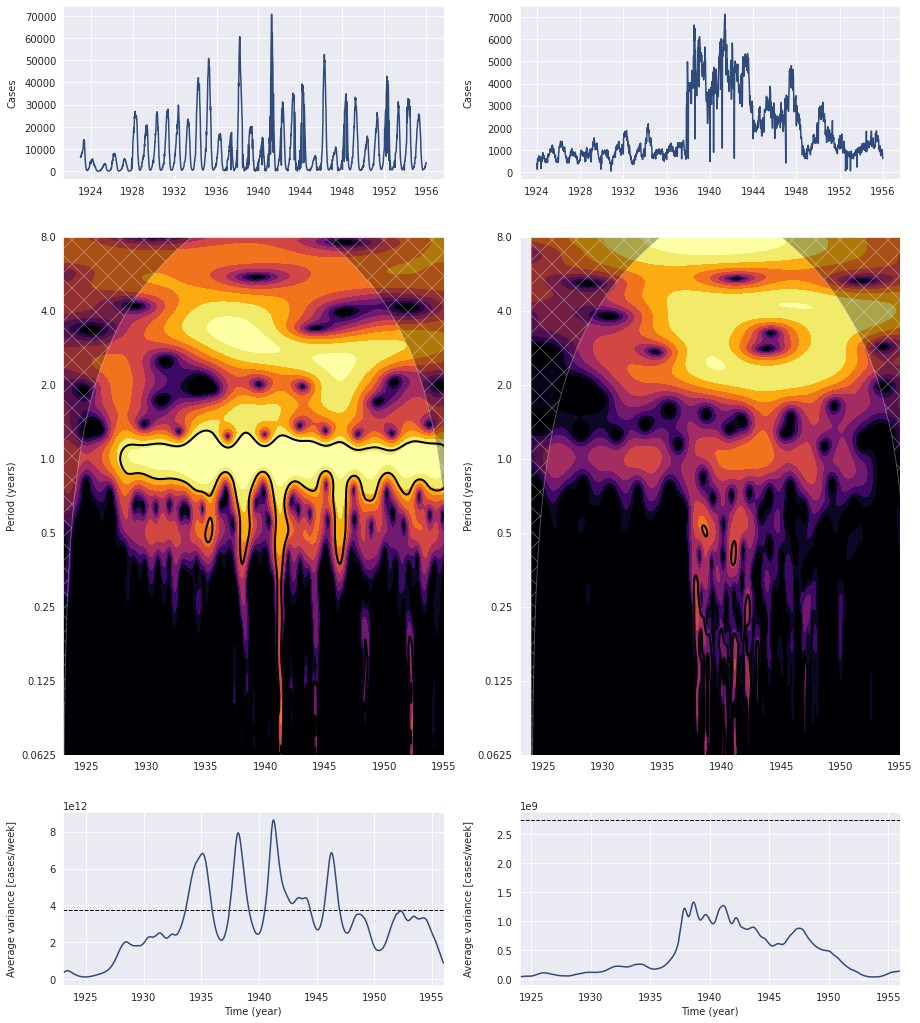

In [7]:
val = plot_cwt(measles_incidence.CountValue, pertussis_incidence.CountValue)
val.savefig("cwt.pdf")
